In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import sklearn 
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve, accuracy_score, f1_score, balanced_accuracy_score, matthews_corrcoef, confusion_matrix, auc, classification_report,cohen_kappa_score
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier
import datetime
import warnings
import random

In [ ]:
!pip install pyAgrum

In [ ]:
from pyAgrum.skbn import BNClassifier

# **Dataset input**

In [ ]:
training = pd.read_csv('/content/gdrive/MyDrive/TAI/reduced_training_set_with_micro_label.csv')
testing = pd.read_csv('/content/gdrive/MyDrive/TAI/reduced_testing_set_with_micro_label.csv')
X_train = training.iloc[:, 1:-1]
y_train = training.iloc[:, -1]
X_test = testing.iloc[:, 1:-1]
y_test = testing.iloc[:, -1]
test_id = testing.iloc[:, 0]

In [ ]:
X_train.head(5)

,original_shape_Elongation,original_firstorder_Skewness,wavelet2-LHL_gldm_LargeDependenceEmphasis,wavelet-LHL_glrlm_LongRunEmphasis,wavelet-LHL_glrlm_RunPercentage,wavelet-HHH_glrlm_RunLengthNonUniformityNormalized,wavelet-LHH_glrlm_ShortRunEmphasis,wavelet-LHL_glrlm_RunLengthNonUniformityNormalized,log-sigma-3-0-mm-3D_gldm_LargeDependenceLowGrayLevelEmphasis,wavelet-HHH_glrlm_ShortRunEmphasis,...,wavelet2-LLL_glcm_Contrast,wavelet2-LHH_glrlm_ShortRunLowGrayLevelEmphasis,wavelet-HHH_firstorder_90Percentile,log-sigma-3-0-mm-3D_gldm_SmallDependenceHighGrayLevelEmphasis,original_firstorder_Kurtosis.1,wavelet2-HLL_firstorder_RootMeanSquared,wavelet-LLL_glszm_LargeAreaLowGrayLevelEmphasis,original_shape_SphericalDisproportion,wavelet2-HHL_glcm_Idmn,Micro Label
0,0.746498,0.308239,15.166667,1.483094,1.231011,0.779418,0.905023,0.762728,30.000000,0.905239,...,21.472746,0.464768,0.971789,0.199476,1.627599,38.364922,9.675926,1.000196,0.923905,0
1,0.629092,0.397052,4194.479987,23.678905,0.405498,0.389592,0.634210,0.204996,703.296082,0.635754,...,214.424383,0.347917,0.380856,0.008536,2.051976,3.412361,3.241028,1.329506,0.896269,1
2,0.784976,0.993808,12.800000,1.911518,1.107642,0.822129,0.934434,0.616016,15.800000,0.925524,...,6.343563,0.306492,0.909483,0.128263,2.777778,16.701131,20.000000,0.996453,0.928254,0
3,0.577087,0.710759,2896.170217,15.066560,0.485534,0.396913,0.639746,0.223692,1765.250000,0.643523,...,70.835116,0.358830,0.466787,0.001531,2.603525,7.192055,220.845578,1.402542,0.895293,0
4,0.830552,0.522244,738.784091,6.039749,0.667421,0.484016,0.689224,0.284998,2168.602273,0.721316,...,52.121725,0.359239,1.302800,0.000626,2.354637,16.746710,17.550530,1.114944,0.910136,1


In [ ]:
print(X_train.shape)
print(X_test.shape)

(2434, 39)
(1128, 39)


# **Algorithm construction**
Group predictions per micro as the final labels of patients 

In [ ]:
# probs (ndarray): the predicted probilities of micro records being classified as positive labels
# return predicted labels, real labels, and predicted probilities of patients
def groupResult(probs):
  # df: corresponding patient id | probility of being classified as 1 | the real label
  result = pd.DataFrame({"Patient ID": test_id.tolist(), "Probability": probs.tolist(), "Label": y_test.tolist()})
  result = result.sort_values(by='Patient ID')
  # get the id set
  ids = set(test_id.tolist())

  real_labels = []
  predicted_labels = []
  # calculated mean probility per patient
  cal_probs = []

  for i in ids:
    # get the result records by patient id
    selected = result[result["Patient ID"] == i]
    # calculate the mean probility of being classified as positive label
    mean_prob = np.mean(selected["Probability"].tolist())
    if mean_prob > 0.5:
      predicted_label = 1
    else:
      predicted_label = 0
  
    predicted_labels.append(predicted_label)
    real_labels.append(selected['Label'].tolist()[0])
    cal_probs.append(mean_prob)

  # result_per_patient = pd.DataFrame({"Patient ID": list(ids), "Predicted Label": predicted_labels, "Real Label": real_labels})
  # return result_per_patient
  return predicted_labels, real_labels, cal_probs


# **Decision Tree**

Fitting 5 folds for each of 18 candidates, totalling 90 fits
{'class_weight': {0: 2, 1: 1, 2: 2}, 'max_depth': 8, 'max_features': 8}


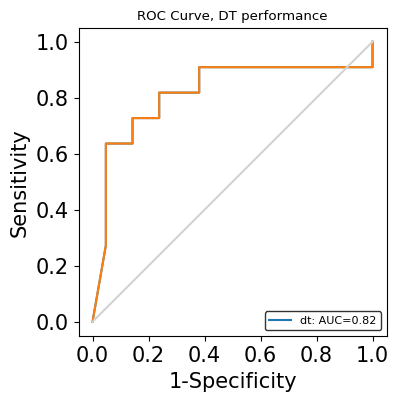

AUC: 0.8160173160173161
Accuracy: 0.78125
Sensitivity: 0.8181818181818182
Specificity: 0.7619047619047619
F1 Score: 0.7200000000000001
running time: 0.708484


<Figure size 640x480 with 0 Axes>

In [ ]:
random.seed(42)

parameters = {'max_depth':[6, 8], 'max_features':[4,6,8],'class_weight':[None,'balanced',{0:2,1:1,2:2}]}
Dtree = DecisionTreeClassifier()
# GridSearchCV searching for the best parameters
dt_grid = GridSearchCV(Dtree, parameters, verbose=1, n_jobs=1,cv=5,scoring='f1_micro')
dt_grid.fit(X_train, y_train)
print(dt_grid.best_params_)

dt_start_time = datetime.datetime.now()
# model training
Dtree = DecisionTreeClassifier(**dt_grid.best_params_, random_state=42)
Dtree.fit(X_train,y_train)

# the probility of being 1
dt_probilities = Dtree.predict_proba(X_test)[:, 1]
# get the processed results of patients
dt_predic_label, dt_real_label, dt_probs = groupResult(dt_probilities)
# confusion matrix construction
confusion = confusion_matrix(dt_real_label, dt_predic_label)
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]

dt_AUC = roc_auc_score(dt_real_label, dt_probs)
dt_ACC = accuracy_score(dt_real_label, dt_predic_label)
dt_Sen = TP / float(TP+FN)
dt_Spe = TN / float(TN+FP)
dt_F1 = f1_score(dt_real_label, dt_predic_label)

# plot roc curve
dt_fpr, dt_tpr, dt_thresholds = roc_curve(dt_real_label, dt_probs, pos_label=None, sample_weight=None, drop_intermediate=True)
dt_auc = roc_auc_score(dt_real_label, dt_probs)

plt.figure(figsize=(6, 4))
plt.plot(dt_fpr, dt_tpr, label='dt: AUC={0:0.2f}'.format(dt_auc))
plt.plot(dt_fpr, dt_tpr)
plt.title("ROC Curve, DT performance")
plt.xlabel('1-Specificity', fontsize=15)
plt.ylabel('Sensitivity', fontsize=15)
plt.axis('square')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.plot([0,1], [0,1], ls = '-', c = 'lightgrey')# 'r--'
plt.rcParams.update({'font.size': 8})
plt.legend(loc="lower right", edgecolor='black')
plt.show()
plt.savefig("/content/gdrive/MyDrive/TAI/dt_roc_task2.jpg")

print("AUC: %s" % (dt_AUC))
print("Accuracy: %s" % (dt_ACC))
print("Sensitivity: %s" % (dt_Sen))
print("Specificity: %s" % (dt_Spe))
print("F1 Score: %s" % (dt_F1))

dt_end_time = datetime.datetime.now()
dt_running_time = (dt_end_time - dt_start_time).total_seconds()
print('running time: %s'%(dt_running_time))


# **Multi-layer Perceptron**

Fitting 5 folds for each of 24 candidates, totalling 120 fits
{'alpha': 0.0001, 'hidden_layer_sizes': 50, 'learning_rate': 'invscaling'}


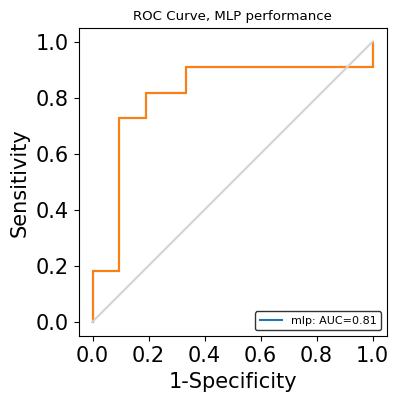

AUC: 0.8095238095238095
Accuracy: 0.71875
Sensitivity: 0.8181818181818182
Specificity: 0.6666666666666666
F1 Score: 0.6666666666666666
running time: 3.629017


<Figure size 640x480 with 0 Axes>

In [ ]:
parameters = {'learning_rate':['constant', 'invscaling'], 'alpha':[0.001, 0.0001, 0.00001], 'hidden_layer_sizes':np.arange(50, 150, 25)}

mlp = MLPClassifier()
mlp_grid = GridSearchCV(mlp, parameters, verbose=1, n_jobs=1,cv=5,scoring='f1_micro')
mlp_grid.fit(X_train, y_train)
print(mlp_grid.best_params_)

mlp_start_time = datetime.datetime.now()

mlp = MLPClassifier(**mlp_grid.best_params_, random_state=42)
mlp.fit(X_train,y_train)
# mlp_predictions = mlp.predict(X_test)
mlp_probilities = mlp.predict_proba(X_test)[:, 1]

mlp_predic_label, mlp_real_label, mlp_probs = groupResult(mlp_probilities)
confusion = confusion_matrix(mlp_real_label, mlp_predic_label)
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]

mlp_AUC = roc_auc_score(mlp_real_label, mlp_probs)
mlp_ACC = accuracy_score(mlp_real_label, mlp_predic_label)
mlp_Sen = TP / float(TP+FN)
mlp_Spe = TN / float(TN+FP)
mlp_F1 = f1_score(mlp_real_label, mlp_predic_label)


mlp_fpr, mlp_tpr, mlp_thresholds = roc_curve(mlp_real_label, mlp_probs, pos_label=None, sample_weight=None, drop_intermediate=True)
mlp_auc = roc_auc_score(mlp_real_label, mlp_probs)

plt.figure(figsize=(6, 4))
plt.plot(mlp_fpr, mlp_tpr, label='mlp: AUC={0:0.2f}'.format(mlp_auc))
plt.plot(mlp_fpr, mlp_tpr)
plt.title("ROC Curve, MLP performance")
plt.xlabel('1-Specificity', fontsize=15)
plt.ylabel('Sensitivity', fontsize=15)
plt.axis('square')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.plot([0,1], [0,1], ls = '-', c = 'lightgrey')# 'r--'
plt.rcParams.update({'font.size': 8})
plt.legend(loc="lower right", edgecolor='black')
plt.show()
plt.savefig("/content/gdrive/MyDrive/TAI/mlp_roc_task2.jpg")

print("AUC: %s" % (mlp_AUC))
print("Accuracy: %s" % (mlp_ACC))
print("Sensitivity: %s" % (mlp_Sen))
print("Specificity: %s" % (mlp_Spe))
print("F1 Score: %s" % (mlp_F1))

mlp_end_time = datetime.datetime.now()
mlp_running_time = (mlp_end_time - mlp_start_time).total_seconds()
print('running time: %s'%(mlp_running_time))

# **Bayesian Network**

Fitting 5 folds for each of 27 candidates, totalling 135 fits
{'learningMethod': 'GHC', 'prior': 'Smoothing', 'scoringType': 'AIC'}


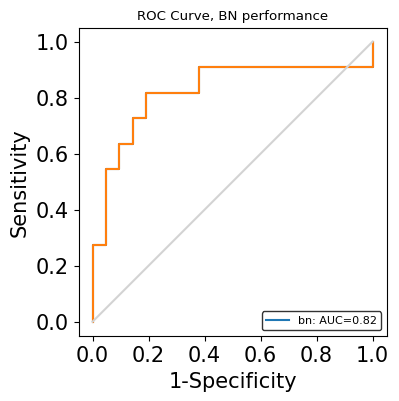

AUC: 0.8225108225108225
Accuracy: 0.78125
Sensitivity: 0.8181818181818182
Specificity: 0.7619047619047619
F1 Score: 0.7200000000000001
running time: 1.66502


<Figure size 640x480 with 0 Axes>

In [ ]:
import warnings
warnings.filterwarnings('ignore')

parameters = {'learningMethod':['GHC', 'MIIC', 'TAN']
              ,'prior':['Smoothing', 'BDeu', None]
              ,'scoringType':['AIC', 'BIC', 'Log2']}

bn = BNClassifier()
bn_grid = GridSearchCV(bn, parameters, verbose=1, n_jobs=1,cv=5,scoring='f1_micro')
bn_grid.fit(X_train, y_train)
print(bn_grid.best_params_)

bn_start_time = datetime.datetime.now()

bn = BNClassifier(**bn_grid.best_params_)
bn.fit(X_train,y_train)
# bn_predictions = bn.predict(X_test)
bn_probilities = bn.predict_proba(X_test)[:, 1]

bn_predic_label, bn_real_label, bn_probs = groupResult(bn_probilities)
confusion = confusion_matrix(bn_real_label, bn_predic_label)
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]

bn_AUC = roc_auc_score(bn_real_label, bn_probs)
bn_ACC = accuracy_score(bn_real_label, bn_predic_label)
bn_Sen = TP / float(TP+FN)
bn_Spe = TN / float(TN+FP)
bn_F1 = f1_score(bn_real_label, bn_predic_label)


bn_fpr, bn_tpr, bn_thresholds = roc_curve(bn_real_label, bn_probs, pos_label=None, sample_weight=None, drop_intermediate=True)
bn_auc = roc_auc_score(bn_real_label, bn_probs)

plt.figure(figsize=(6, 4))
plt.plot(bn_fpr, bn_tpr, label='bn: AUC={0:0.2f}'.format(bn_auc))
plt.plot(bn_fpr, bn_tpr)
plt.title("ROC Curve, BN performance")
plt.xlabel('1-Specificity', fontsize=15)
plt.ylabel('Sensitivity', fontsize=15)
plt.axis('square')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.plot([0,1], [0,1], ls = '-', c = 'lightgrey')# 'r--'
plt.rcParams.update({'font.size': 8})
plt.legend(loc="lower right", edgecolor='black')
plt.show()
plt.savefig("/content/gdrive/MyDrive/TAI/bn_roc_task2.jpg")

print("AUC: %s" % (bn_AUC))
print("Accuracy: %s" % (bn_ACC))
print("Sensitivity: %s" % (bn_Sen))
print("Specificity: %s" % (bn_Spe))
print("F1 Score: %s" % (bn_F1))


bn_end_time = datetime.datetime.now()
bn_running_time = (bn_end_time - bn_start_time).total_seconds()
print('running time: %s'%(bn_running_time))

# **Random Forest**

Fitting 5 folds for each of 18 candidates, totalling 90 fits
{'max_depth': 6, 'max_features': 'sqrt', 'n_estimators': 200}


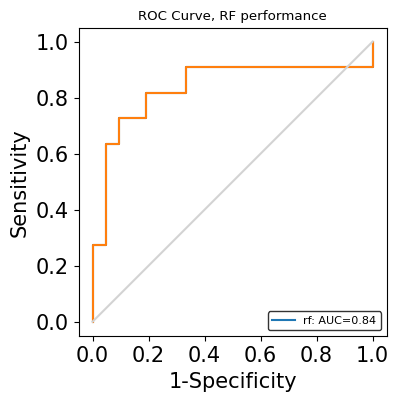

AUC: 0.8354978354978355
Accuracy: 0.78125
Sensitivity: 0.8181818181818182
Specificity: 0.7619047619047619
F1 Score: 0.7200000000000001
running time: 2.869993


<Figure size 640x480 with 0 Axes>

In [ ]:
parameters = { 
    'n_estimators': [200, 400, 500],
    'max_features': ['sqrt', 'log2'],
    'max_depth' : [6, 8, 10]}
rf = RandomForestClassifier()
rf_grid = GridSearchCV(rf, parameters, verbose=1, n_jobs=1,cv=5,scoring='f1_micro')
rf_grid.fit(X_train, y_train)
print(rf_grid.best_params_)

rf_start_time = datetime.datetime.now()

rf = RandomForestClassifier(**rf_grid.best_params_, random_state=42)
rf.fit(X_train,y_train)
# rf_predictions = rf.predict(X_test)
rf_probilities = rf.predict_proba(X_test)[:, 1]

rf_predic_label, rf_real_label, rf_probs = groupResult(rf_probilities)
confusion = confusion_matrix(rf_real_label, rf_predic_label)
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]

rf_AUC = roc_auc_score(rf_real_label, rf_probs)
rf_ACC = accuracy_score(rf_real_label, rf_predic_label)
rf_Sen = TP / float(TP+FN)
rf_Spe = TN / float(TN+FP)
rf_F1 = f1_score(rf_real_label, rf_predic_label)

rf_fpr, rf_tpr, rf_thresholds = roc_curve(rf_real_label, rf_probs, pos_label=None, sample_weight=None, drop_intermediate=True)
rf_auc = roc_auc_score(rf_real_label, rf_probs)

plt.figure(figsize=(6, 4))
plt.plot(rf_fpr, rf_tpr, label='rf: AUC={0:0.2f}'.format(rf_auc))
plt.plot(rf_fpr, rf_tpr)
plt.title("ROC Curve, RF performance")
plt.xlabel('1-Specificity', fontsize=15)
plt.ylabel('Sensitivity', fontsize=15)
plt.axis('square')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.plot([0,1], [0,1], ls = '-', c = 'lightgrey')# 'r--'
plt.rcParams.update({'font.size': 8})
plt.legend(loc="lower right", edgecolor='black')
plt.show()
plt.savefig("/content/gdrive/MyDrive/TAI/rf_roc_task2.jpg")

print("AUC: %s" % (rf_AUC))
print("Accuracy: %s" % (rf_ACC))
print("Sensitivity: %s" % (rf_Sen))
print("Specificity: %s" % (rf_Spe))
print("F1 Score: %s" % (rf_F1))


rf_end_time = datetime.datetime.now()
rf_running_time = (rf_end_time - rf_start_time).total_seconds()
print('running time: %s'%(rf_running_time))

Plot all roc curves

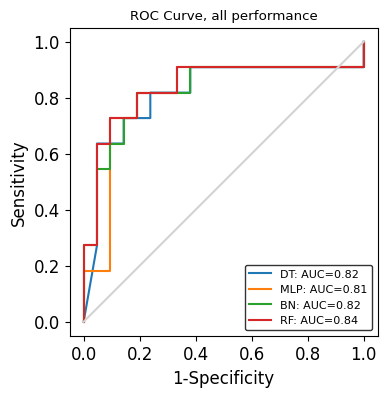

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.figure(figsize=(6, 4))
plt.plot(dt_fpr, dt_tpr, label='DT: AUC={0:0.2f}'.format(dt_AUC))
plt.plot(mlp_fpr, mlp_tpr, label='MLP: AUC={0:0.2f}'.format(mlp_AUC))
plt.plot(bn_fpr, bn_tpr, label='BN: AUC={0:0.2f}'.format(bn_AUC))
plt.plot(rf_fpr, rf_tpr, label='RF: AUC={0:0.2f}'.format(rf_AUC))
plt.title("ROC Curve, all performance")
plt.xlabel('1-Specificity', fontsize=12)
plt.ylabel('Sensitivity', fontsize=12)
plt.axis('square')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.plot([0,1], [0,1], ls = '-', c = 'lightgrey')# 'r--'
#plt.grid(True)
plt.rcParams.update({'font.size': 8})
plt.legend(loc="best", edgecolor='black')
plt.show()
plt.savefig("/content/gdrive/MyDrive/TAI/all_roc_task2.jpg")

map results to a table

In [ ]:
stat = ["AUC", "Accuracy", "Sensitivity", "Specificity", "F1 Score", "Running time (second)"]

dt_result = [dt_AUC, dt_ACC, dt_Sen, dt_Spe, dt_F1, dt_running_time]
mlp_result = [mlp_AUC, mlp_ACC, mlp_Sen, mlp_Spe, mlp_F1, mlp_running_time]
bn_result = [bn_AUC, bn_ACC, bn_Sen, bn_Spe, bn_F1, bn_running_time]
rf_result = [rf_AUC, rf_ACC, rf_Sen, rf_Spe, rf_F1, rf_running_time]

for i in range(len(dt_result)):
  dt_result[i] = round(dt_result[i], 2)
  mlp_result[i] = round(mlp_result[i], 2)
  bn_result[i] = round(bn_result[i], 2)
  rf_result[i] = round(rf_result[i], 2)

result_df = pd.DataFrame({" ":stat, "DT": dt_result, "MLP": mlp_result, "BN": bn_result, "RF": rf_result})

result_df.to_csv('/content/gdrive/MyDrive/TAI/result_task2.csv', index=False)

result_df

,,DT,MLP,BN,RF
0,AUC,0.82,0.81,0.82,0.84
1,Accuracy,0.78,0.72,0.78,0.78
2,Sensitivity,0.82,0.82,0.82,0.82
3,Specificity,0.76,0.67,0.76,0.76
4,F1 Score,0.72,0.67,0.72,0.72
5,Running time (second),0.71,3.63,1.67,2.87
